[*********************100%***********************]  1 of 1 completed
Epoch 1/50
88/88 [==============================] - 7s 43ms/step - loss: 0.0166
Epoch 2/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0028
Epoch 3/50
88/88 [==============================] - 4s 47ms/step - loss: 0.0024
Epoch 4/50
88/88 [==============================] - 4s 46ms/step - loss: 0.0020
Epoch 5/50
88/88 [==============================] - 4s 48ms/step - loss: 0.0020
Epoch 6/50
88/88 [==============================] - 5s 54ms/step - loss: 0.0020
Epoch 7/50
88/88 [==============================] - 4s 45ms/step - loss: 0.0017
Epoch 8/50
88/88 [==============================] - 4s 47ms/step - loss: 0.0018
Epoch 9/50
88/88 [==============================] - 4s 49ms/step - loss: 0.0020
Epoch 10/50
88/88 [==============================] - 5s 53ms/step - loss: 0.0015
Epoch 11/50
88/88 [==============================] - 5s 53ms/step - loss: 0.0018
Epoch 12/50
88/88 [==============================

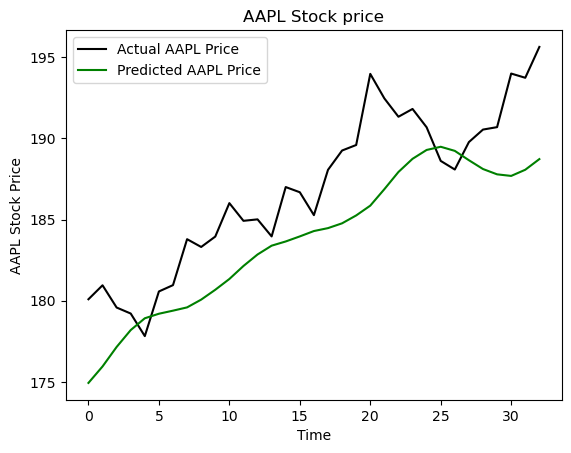

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the stock price data
company = 'AAPL'

start = dt.datetime(2012, 1, 1)
end = dt.datetime(2023, 6, 1)

data = yf.download(company, start=start, end=end)

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(prediction_days, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of the next closing value

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=32)

''' Test The Model Accuracy on Existing data '''

# Load Test Data
test_start = dt.datetime(2023, 6, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Make Prediction on Test Data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# plot the test predictions
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color='green', label=f"Predicted {company} Price")
plt.title(f"{company} Stock price")
plt.xlabel('Time')
plt.ylabel(f'{company} Stock Price')
plt.legend()
plt.show()
